
# Day 51｜在预训练 ResNet18 中注入 CBAM 注意力

结合昨天的基础实验，今天记录如何把 CBAM 注意力插入预训练 ResNet18 并用分阶段微调提升 CIFAR-10 分类效果。



今天要回答两个问题：
1. ResNet18 中如何插入 CBAM 模块而不破坏预训练权重？
2. 采用什么预训练/微调策略能更快提高效率？

核心原则：保留预训练特征提取器的价值，只在合适位置加注意力，并通过渐进解冻避免大幅扰动。



## 路线速览
- 复用 CIFAR-10 数据增强与归一化流程。
- 回顾 ResNet18 的层级结构、BasicBlock 与特征图尺寸演化。
- 讨论 CBAM 放置位置：末端 vs. 每个残差块后，并解释为什么后者可行。
- 编写 `ResNet18CBAM`，调整首层卷积/MaxPool 以适配 32x32 输入。
- 采用差异化学习率 + 三阶段解冻策略完成微调与可视化。


In [1]:

import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np

# 基本设置
plt.rcParams['font.family'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 避免中文环境下负号显示成方块
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用设备: {device}')


使用设备: cuda



## 数据预处理与加载
CIFAR-10 只有 32x32 分辨率，使用轻量级增强即可：随机裁剪、翻转、颜色抖动、随机旋转，并配合标准归一化。


In [2]:

# 数据增强与归一化
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 数据集与 DataLoader
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

print(f'训练集: {len(train_dataset)} 张, 测试集: {len(test_dataset)} 张')


训练集: 50000 张, 测试集: 10000 张



## ResNet18 结构速览
经典 ResNet18 可以拆成三段：输入预处理 (stem)、四个残差 stage、分类头。

| 阶段 | 对应层级 | 主要作用 |
| :-- | :-- | :-- |
| 输入预处理 (Stem) | `conv1 → bn1 → relu → maxpool` | 将 224x224 图像下采样到 56x56，提取浅层纹理 |
| 核心特征提取 | `layer1` ~ `layer4` (每组 2 个 BasicBlock) | 逐步减半空间分辨率、通道数翻倍，累积语义 |
| 分类输出 (Head) | `avgpool → fc` | 全局平均池化后接线性层完成分类 |



### 特征图尺寸演化（输入 1x3x224x224）
| 位置 | 输出尺寸 | 变化说明 |
| :-- | :-- | :-- |
| conv1 (7x7, stride=2) | `[1, 64, 112, 112]` | 通道 3→64，尺寸减半 |
| maxpool (3x3, stride=2) | `[1, 64, 56, 56]` | 继续减半 |
| layer1 | `[1, 64, 56, 56]` | 2 个 BasicBlock，尺寸/通道不变 |
| layer2 | `[1, 128, 28, 28]` | 第一个块完成下采样与通道翻倍 |
| layer3 | `[1, 256, 14, 14]` | 同上 |
| layer4 | `[1, 512, 7, 7]` | 同上 |
| avgpool → fc | `[1, 1000]` | 池化为 1x1 后接全连接 |



### BasicBlock 残差思想
- 主路：`3x3 conv → BN → ReLU → 3x3 conv → BN` 学习残差 `F(x)`；
- 捷径：直接把输入 `x` 传到输出；
- 先求和再 ReLU：`H(x) = F(x) + x`，让网络学习“差值”而非完整映射，降低退化风险并提供梯度捷径。


In [3]:

# 可选：查看 ResNet18 结构（使用随机初始化避免联网下载权重）
resnet18 = models.resnet18(weights=None)
resnet18.eval()
summary(resnet18, input_size=(1, 3, 224, 224))


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│


## CBAM 放置位置的思考
1. 直接放在分类头前：实现最简单，但空间注意力在 1x1 特征上失效，只剩通道注意力。
2. 放在每个残差块后（推荐）：让注意力在中间层就参与特征重标定，同时不破坏预训练权重，因为 CBAM 初始化近似直通：
   - 随机初始化时注意力输出接近 0，`sigmoid(0)=0.5`，等价于把特征整体缩放一半，结构信息未被破坏；
   - 如果注意力无用，网络会把权重学到常数，近似 `x*1`；有用则自动聚焦重要通道与空间。



## CBAM 模块实现
通道注意力：全局平均池化 + 最大池化，共享 MLP 得到通道权重；
空间注意力：在通道维做均值/最大池化并拼接，经 7x7 卷积得到空间权重。


In [4]:

class ChannelAttention(nn.Module):
    def __init__(self, in_channels, ratio=16):
        super().__init__()
        # 共享的两层全连接：降维后再升回去，学习通道间关系
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // ratio, bias=False),
            nn.ReLU(),
            nn.Linear(in_channels // ratio, in_channels, bias=False),
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.shape
        avg_out = self.fc(self.avg_pool(x).view(b, c))
        max_out = self.fc(self.max_pool(x).view(b, c))
        attn = self.sigmoid(avg_out + max_out).view(b, c, 1, 1)
        return x * attn


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        pooled = torch.cat([avg_out, max_out], dim=1)
        attn = self.sigmoid(self.conv(pooled))
        return x * attn


class CBAM(nn.Module):
    def __init__(self, in_channels, ratio=16, kernel_size=7):
        super().__init__()
        self.channel_attn = ChannelAttention(in_channels, ratio)
        self.spatial_attn = SpatialAttention(kernel_size)

    def forward(self, x):
        x = self.channel_attn(x)
        x = self.spatial_attn(x)
        return x



## 将 CBAM 注入 ResNet18
- 使用 `weights=ResNet18_Weights.DEFAULT` 加载预训练权重（若无法联网，将自动降级为随机初始化）。
- 首层卷积改为 3x3, stride=1，移除 MaxPool 以适配 32x32。
- 在 `layer1~4` 输出后各加一个 CBAM 模块。
- 分类头输出改为 10 类。


In [5]:

class ResNet18CBAM(nn.Module):
    def __init__(self, num_classes=10, pretrained=True, cbam_ratio=16, cbam_kernel=7):
        super().__init__()
        weights = models.ResNet18_Weights.DEFAULT if pretrained else None
        try:
            self.backbone = models.resnet18(weights=weights)
        except Exception as e:
            print(f'预训练权重加载失败，改用随机初始化: {e}')
            self.backbone = models.resnet18(weights=None)

        # 调整首层以适应 32x32 输入；原始设定针对 224x224
        self.backbone.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.backbone.maxpool = nn.Identity()  # 小分辨率下不再需要初始池化

        # 在四个 stage 后各插入一个 CBAM
        self.cbam1 = CBAM(64, ratio=cbam_ratio, kernel_size=cbam_kernel)
        self.cbam2 = CBAM(128, ratio=cbam_ratio, kernel_size=cbam_kernel)
        self.cbam3 = CBAM(256, ratio=cbam_ratio, kernel_size=cbam_kernel)
        self.cbam4 = CBAM(512, ratio=cbam_ratio, kernel_size=cbam_kernel)

        # 分类头输出 10 类
        self.backbone.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        # stem
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)  # [B, 64, 32, 32]

        # layer1 + CBAM
        x = self.backbone.layer1(x)  # [B, 64, 32, 32]
        x = self.cbam1(x)

        # layer2 + CBAM
        x = self.backbone.layer2(x)  # [B, 128, 16, 16]
        x = self.cbam2(x)

        # layer3 + CBAM
        x = self.backbone.layer3(x)  # [B, 256, 8, 8]
        x = self.cbam3(x)

        # layer4 + CBAM
        x = self.backbone.layer4(x)  # [B, 512, 4, 4]
        x = self.cbam4(x)

        # 分类头
        x = self.backbone.avgpool(x)  # [B, 512, 1, 1]
        x = torch.flatten(x, 1)
        x = self.backbone.fc(x)
        return x



## 训练策略：差异化学习率 + 三阶段解冻
把预训练卷积分成“资深专家”，新加的 CBAM 与分类头当作“实习生”。
- 专家：需要小步微调，学习率设得很低。
- 实习生：从零学习，学习率可大一些。
三阶段策略（可根据算力调小 epoch 先试跑）：

| 阶段 | epoch 范围 | 解冻层 | 学习率 | 目的 |
| :-- | :-- | :-- | :-- | :-- |
| 1 | 1-5 | 仅 CBAM + `fc` | 1e-3 | 先让新模块找到关注点，确定分类边界 |
| 2 | 6-20 | CBAM + `fc` + `layer3`、`layer4` | 1e-4 | 解冻高层语义特征，适应任务 |
| 3 | 21-50 | 全部层 | 1e-5 | 全局微调，微小步长避免遗忘 |


In [6]:

def set_trainable_layers(model, trainable_parts):
    # 先冻结全部参数，再按名字关键字解冻指定模块
    for name, param in model.named_parameters():
        param.requires_grad = False
        if any(part in name for part in trainable_parts):
            param.requires_grad = True


def train_staged_finetuning(model, criterion, train_loader, test_loader, device, epochs=50):
    history = {
        'iter_indices': [],
        'iter_losses': [],
        'train_acc': [],
        'test_acc': [],
        'train_loss': [],
        'test_loss': [],
    }
    optimizer = None

    for epoch in range(1, epochs + 1):
        # 动态切换解冻范围与学习率
        if epoch == 1:
            set_trainable_layers(model, ['cbam', 'backbone.fc'])
            optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
        elif epoch == 6:
            set_trainable_layers(model, ['cbam', 'backbone.fc', 'backbone.layer3', 'backbone.layer4'])
            optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
        elif epoch == 21:
            for param in model.parameters():
                param.requires_grad = True
            optimizer = optim.Adam(model.parameters(), lr=1e-5)

        # 训练阶段
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for batch_idx, (data, target) in enumerate(train_loader, start=1):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, pred = output.max(1)
            total += target.size(0)
            correct += pred.eq(target).sum().item()

            history['iter_indices'].append((epoch - 1) * len(train_loader) + batch_idx)
            history['iter_losses'].append(loss.item())

            if batch_idx % 100 == 0:
                avg_loss = running_loss / batch_idx
                print(f'Epoch {epoch:02d}/{epochs} | Batch {batch_idx:03d}/{len(train_loader)} | 单batch损失 {loss.item():.4f} | 均值损失 {avg_loss:.4f}')

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100.0 * correct / total
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)

        # 验证阶段
        model.eval()
        test_loss, correct_test, total_test = 0.0, 0, 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
                _, pred = output.max(1)
                total_test += target.size(0)
                correct_test += pred.eq(target).sum().item()

        epoch_test_loss = test_loss / len(test_loader)
        epoch_test_acc = 100.0 * correct_test / total_test
        history['test_loss'].append(epoch_test_loss)
        history['test_acc'].append(epoch_test_acc)

        print(f'Epoch {epoch:02d}/{epochs} | 训练Acc {epoch_train_acc:.2f}% | 测试Acc {epoch_test_acc:.2f}%')

    return history


def plot_iter_losses(history):
    plt.figure(figsize=(10, 4))
    plt.plot(history['iter_indices'], history['iter_losses'], alpha=0.7)
    plt.xlabel('Iteration (batch)')
    plt.ylabel('Loss')
    plt.title('Iteration 级别训练损失')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_epoch_metrics(history):
    epochs = range(1, len(history['train_acc']) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_acc'], label='训练准确率')
    plt.plot(epochs, history['test_acc'], label='测试准确率')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('准确率曲线')
    plt.legend(); plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_loss'], label='训练损失')
    plt.plot(epochs, history['test_loss'], label='测试损失')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('损失曲线')
    plt.legend(); plt.grid(True)
    plt.tight_layout()
    plt.show()



## 开始训练
默认跑 50 个 epoch；算力有限时可先跑 5~10 轮确认流程，再拉满。


开始分阶段微调...
Epoch 01/50 | Batch 100/782 | 单batch损失 2.2254 | 均值损失 2.1764
Epoch 01/50 | Batch 200/782 | 单batch损失 1.8532 | 均值损失 2.0260
Epoch 01/50 | Batch 300/782 | 单batch损失 1.4626 | 均值损失 1.9374
Epoch 01/50 | Batch 400/782 | 单batch损失 1.6439 | 均值损失 1.8802
Epoch 01/50 | Batch 500/782 | 单batch损失 1.5029 | 均值损失 1.8403
Epoch 01/50 | Batch 600/782 | 单batch损失 1.7956 | 均值损失 1.8095
Epoch 01/50 | Batch 700/782 | 单batch损失 1.8239 | 均值损失 1.7830
Epoch 01/50 | 训练Acc 36.14% | 测试Acc 46.28%
Epoch 02/50 | Batch 100/782 | 单batch损失 1.6897 | 均值损失 1.5919
Epoch 02/50 | Batch 200/782 | 单batch损失 1.4652 | 均值损失 1.5834
Epoch 02/50 | Batch 300/782 | 单batch损失 1.6862 | 均值损失 1.5734
Epoch 02/50 | Batch 400/782 | 单batch损失 1.3500 | 均值损失 1.5697
Epoch 02/50 | Batch 500/782 | 单batch损失 1.5694 | 均值损失 1.5621
Epoch 02/50 | Batch 600/782 | 单batch损失 1.5129 | 均值损失 1.5561
Epoch 02/50 | Batch 700/782 | 单batch损失 1.2951 | 均值损失 1.5493
Epoch 02/50 | 训练Acc 44.97% | 测试Acc 50.53%
Epoch 03/50 | Batch 100/782 | 单batch损失 1.3975 | 均值损失 1.5060
Epoch

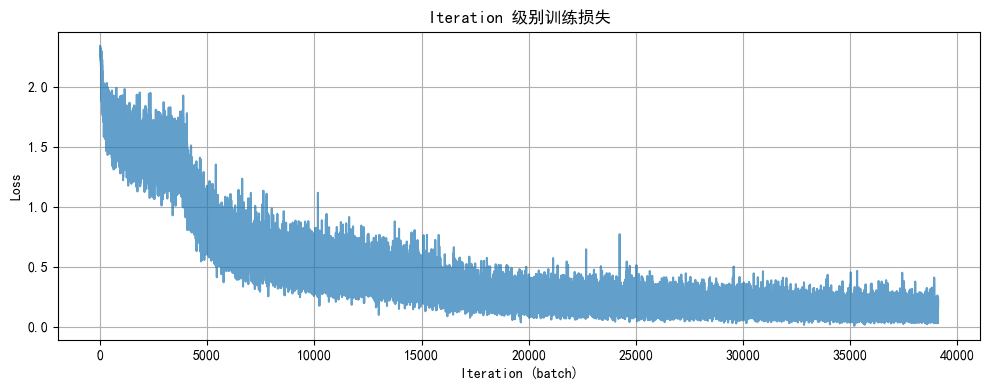

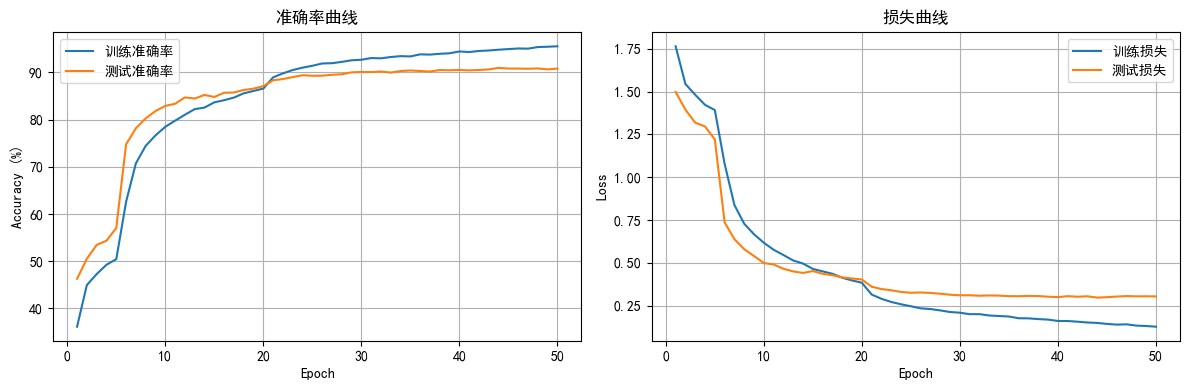

模型已保存到 resnet18_cbam_finetuned.pth


In [7]:

epochs = 50  # 可根据算力调整
model = ResNet18CBAM(pretrained=True).to(device)
criterion = nn.CrossEntropyLoss()

print('开始分阶段微调...')
history = train_staged_finetuning(model, criterion, train_loader, test_loader, device, epochs=epochs)

plot_iter_losses(history)
plot_epoch_metrics(history)

torch.save(model.state_dict(), 'resnet18_cbam_finetuned.pth')
print('模型已保存到 resnet18_cbam_finetuned.pth')
